#### Only ViT Encoder Part

# Dependencies

In [5]:
# important
password = input("Enter Password:")
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm, trange
from sklearn.metrics import r2_score
from datetime import datetime

# torch and utilities
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset

# supporting
import os
import gc
import random

# Setting up things
torch.manual_seed(42)
torch.cuda.manual_seed(42)
torch.set_num_threads(20)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device:",device)

Device: cuda


# Model Architecture

In [6]:
class PatchEmbedding(nn.Module):
    def __init__(self, patch_size=8, in_channels=1, emb_dim=128):
        super(PatchEmbedding, self).__init__()
        self.patch_size = patch_size
        self.num_patches = (48 // patch_size) ** 3
        self.proj = nn.Linear(patch_size**3 * in_channels, emb_dim)
        self.pos_embed = nn.Parameter(torch.randn(1, self.num_patches, emb_dim))

    def forward(self, x):
        # x shape: (n, 1, 48, 48, 48)
        n, c, d, h, w = x.shape
        x = x.unfold(2, self.patch_size, self.patch_size).unfold(3, self.patch_size, self.patch_size).unfold(4, self.patch_size, self.patch_size)
        x = x.contiguous().view(n, -1, c*self.patch_size**3)
        x = self.proj(x)
        x = x + self.pos_embed
        return x
    
# output1 = PatchEmbedding()(input_cube)
# print(output1.shape)

class ParameterEmbedding(nn.Module):
    def __init__(self, param_dim=3, emb_dim=128):
        super(ParameterEmbedding, self).__init__()
        self.fc = nn.Linear(param_dim, emb_dim)

    def forward(self, params):
        # params shape: (n, 3)
        param_emb = self.fc(params)
        return param_emb.unsqueeze(1)  # shape: (n, 1, emb_dim)
    
# output2 = ParameterEmbedding()(input_params)
# print(output2.shape)

class TransformerEncoderLayer(nn.Module):
    def __init__(self, emb_dim=128, num_heads=8, ff_dim=256):
        super(TransformerEncoderLayer, self).__init__()
        self.self_attn = nn.MultiheadAttention(emb_dim, num_heads)
        self.fc1 = nn.Linear(emb_dim, ff_dim)
        self.fc2 = nn.Linear(ff_dim, emb_dim)
        self.norm1 = nn.LayerNorm(emb_dim)
        self.norm2 = nn.LayerNorm(emb_dim)

    def forward(self, x):
        attn_output, _ = self.self_attn(x, x, x)
        x = x + attn_output
        x = self.norm1(x)
        ff_output = self.fc2(F.relu(self.fc1(x)))
        x = x + ff_output
        x = self.norm2(x)
        return x

# output3 = TransformerEncoderLayer()(output1)
# print(output3.shape)

class CosmoUiT(nn.Module):
    def __init__(self, patch_size=6, emb_dim=128, num_heads=4, num_layers=4, param_dim=3):
        super(CosmoUiT, self).__init__()
        self.patch_embed = PatchEmbedding(patch_size, emb_dim=emb_dim)
        self.param_embed = ParameterEmbedding(param_dim, emb_dim)
        self.encoder_layers = nn.ModuleList([TransformerEncoderLayer(emb_dim, num_heads) for _ in range(num_layers)])
        self.fc_out = nn.Linear(emb_dim, patch_size**3)

    def forward(self, x, params):
        x = self.patch_embed(x)
        param_emb = self.param_embed(params)
        x = torch.cat((param_emb, x), dim=1)  # Concatenate parameter embedding
        for layer in self.encoder_layers:
            x = layer(x)
        x = self.fc_out(x)  # shape: (n, num_patches, patch_size^3)
        x = self.reconstruct(x[:, 1:217, :])
        return x
    
    def reconstruct(self, x):
        n, num_patches, patch_dim = x.shape
        patch_size = int(round(patch_dim ** (1/3)))
        d = h = w = int(round(num_patches ** (1/3)))
        x = x.view(n, d, h, w, patch_size, patch_size, patch_size)
        x = x.permute(0, 1, 4, 2, 5, 3, 6).contiguous()
        x = x.view(n, 1, d*patch_size, h*patch_size, w*patch_size)  # shape: (n, 1, 48, 48, 48)
        return x

model = CosmoUiT(patch_size=8, emb_dim=128, num_heads=8, num_layers=4, param_dim=3).to(device)
# input_params = torch.randn(10,3).to(device)
# output = model(input_halo, input_params)
# print(output.shape)

In [7]:
# input halo: normalized already
input_halo = torch.load('/media/disk2/prasad/TensorData/InputFields/Halo.pt', weights_only=False).to(device)
print("input halo shape: ",input_halo.shape)

# commented out since we are only using the halo at first
# input dm: normalized already
# assigned halo to save time
# input_halo= torch.load('/media/disk2/prasad/TensorData/InputFields/DM.pt', weights_only=False).to(device)
# print("input dm shape: ", input_halo.shape)

input halo shape:  torch.Size([10, 1, 48, 48, 48])


In [8]:
# plt.imshow(halo[0][0][0], cmap='magma')
# plt.colorbar()
# plt.show()
# plt.imshow(dm[0][0][0])
# plt.show()

# Training Model

In [9]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

num_epochs = 1000
num_training_files = 576
num_validation_files = 144

training_loss = []
training_r2 = []

validation_loss = []
validation_r2 = []

# The model specifications must be edited everytime the model is saved
ModelSpecification = f"CosmoViT{num_epochs}"
folder_path = f'/media/disk1/prasad/codes/RefinedModelOutputs/{ModelSpecification}/'
if not os.path.exists(folder_path):
    os.mkdir(folder_path)


training_start_time = datetime.now()

for i in trange(num_epochs, desc='Epochs'):
    model.train()
    
    train_batch_loss = 0.0
    train_batch_r2 = 0.0
    num_train_batches = 0
    
    for file in trange(num_training_files, desc='Files'):
        optimizer.zero_grad()
        
        output_xHI = torch.load(f'/media/disk2/prasad/TensorData/OutputFields/Training/xHI{file}.pt', weights_only=False).to(device)
        input_params =  torch.load(f'/media/disk2/prasad/TensorData/InputParams/Training/Params{file}.pt', weights_only=False).to(device)

        prediction = model(input_halo, input_params)
        loss = criterion(prediction, output_xHI)
        loss.backward()
        optimizer.step()

        train_batch_loss+=loss.item()
        r2 = r2_score(output_xHI.cpu().numpy().flatten(), prediction.cpu().detach().numpy().flatten())
        train_batch_r2 += r2
        num_train_batches += 1
        # break #uncomment for trial run
        
    training_loss.append(train_batch_loss / num_train_batches)
    training_r2.append(train_batch_r2 / num_train_batches)
    
    model.eval()
    val_batch_loss = 0.0
    val_batch_r2 = 0.0
    num_val_batches = 0    
    with torch.no_grad():
        for file in trange(num_validation_files, desc='files'):
            output_xHI = torch.load(f'/media/disk2/prasad/TensorData/OutputFields/Validation/xHI{file}.pt', weights_only=False).to(device)
            input_params =  torch.load(f'/media/disk2/prasad/TensorData/InputParams/Validation/Params{file}.pt', weights_only=False).to(device)
            
            prediction = model(input_halo, input_params)
            loss = criterion(prediction, output_xHI)
            
            val_batch_loss += loss.item()
            r2 = r2_score(output_xHI.cpu().numpy().flatten(), prediction.cpu().detach().numpy().flatten())
            val_batch_r2+=r2
            num_val_batches += 1
            # break #uncomment for trial run
            
    validation_loss.append(val_batch_loss / num_val_batches)
    validation_r2.append(val_batch_r2 / num_val_batches)
    # break #uncomment for trial run
    
    print(f"Training Loss: {training_loss[-1]}, Training R2: {training_r2[-1]}, Validation Loss: {validation_loss[-1]}, Validation R2: {validation_r2[-1]}")

training_end_time = datetime.now()

Epochs:  10%|█         | 1/10 [00:00<00:01,  5.29it/s]

Training Loss: 0.8531473875045776, Training R2: -3.228053092956543, Validation Loss: 0.7134206891059875, Validation R2: -2.870405673980713


files:   0%|          | 0/144 [00:00<?, ?it/s]


Training Loss: 0.7132896184921265, Training R2: -2.534942388534546, Validation Loss: 0.5849802494049072, Validation R2: -2.1735994815826416


files:   0%|          | 0/144 [00:00<?, ?it/s]


Training Loss: 0.5898005962371826, Training R2: -1.9229507446289062, Validation Loss: 0.47158607840538025, Validation R2: -1.5584197044372559


files:   0%|          | 0/144 [00:00<?, ?it/s]


Training Loss: 0.48096680641174316, Training R2: -1.3835887908935547, Validation Loss: 0.3819746971130371, Validation R2: -1.0722651481628418


Epochs:  50%|█████     | 5/10 [00:00<00:00, 16.03it/s]

Training Loss: 0.3946368992328644, Training R2: -0.9557533264160156, Validation Loss: 0.31687474250793457, Validation R2: -0.7190889120101929


files:   0%|          | 0/144 [00:00<?, ?it/s]


Training Loss: 0.3315589427947998, Training R2: -0.6431493759155273, Validation Loss: 0.27154770493507385, Validation R2: -0.4731835126876831


files:   0%|          | 0/144 [00:00<?, ?it/s]


Training Loss: 0.287505567073822, Training R2: -0.42482876777648926, Validation Loss: 0.24050597846508026, Validation R2: -0.30477821826934814


Epochs:  80%|████████  | 8/10 [00:00<00:00, 20.55it/s]

Training Loss: 0.25740593671798706, Training R2: -0.2756596803665161, Validation Loss: 0.2200077772140503, Validation R2: -0.19357216358184814


files:   0%|          | 0/144 [00:00<?, ?it/s]


Training Loss: 0.2376711517572403, Training R2: -0.1778576374053955, Validation Loss: 0.2076195627450943, Validation R2: -0.1263643503189087


files:   0%|          | 0/144 [00:00<?, ?it/s]


Training Loss: 0.22586654126644135, Training R2: -0.11935591697692871, Validation Loss: 0.20131640136241913, Validation R2: -0.09216904640197754


Epochs: 100%|██████████| 10/10 [00:00<00:00, 18.80it/s]


### Saving Objects
1. Must be edited before each run
2. Keep the model specification unique emphasizing the different model parameters for each model

In [6]:

ModelTexts = f"""
Model Specifications: {ModelSpecification}

Type: UiT
Dark Matter: False
Halo: True

Validation Loss: {validation_loss[-1]}
Training Loss: {training_loss[-1]}

Validation R2:{validation_r2[-1]}
Training R2: {training_r2[-1]}

Training Start Date & Time: {training_start_time}
Training End Date & Time: {training_end_time}
Training Duration:{training_end_time-training_start_time}
"""

In [7]:
with open(f'{folder_path}/ModelSpecification.txt', 'w') as f:
    f.write(ModelTexts)

In [8]:
torch.save(model.state_dict(), f'{folder_path}/{ModelSpecification}.pth')
np.save(f'{folder_path}/training_loss.npy', training_loss)
np.save(f'{folder_path}/validation_loss.npy', validation_loss)
np.save(f'{folder_path}/training_r2.npy', training_r2)
np.save(f'{folder_path}/validation_r2.npy', validation_r2)

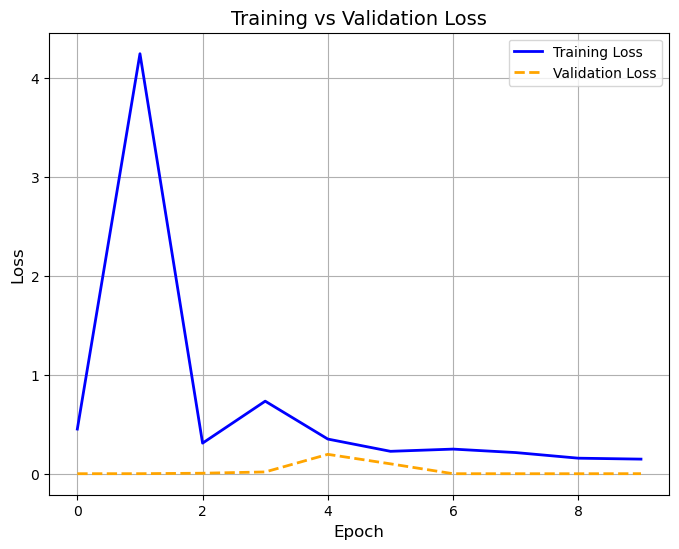

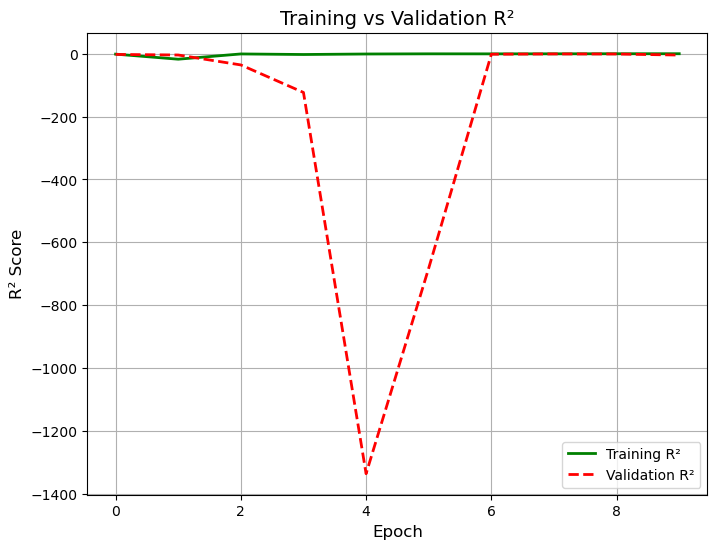

In [9]:
plt.figure(figsize=(8, 6))
plt.plot(training_loss, label='Training Loss', color='blue', linewidth=2)
plt.plot(validation_loss, label='Validation Loss', color='orange', linestyle='--', linewidth=2)
plt.title('Training vs Validation Loss', fontsize=14)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend(loc='upper right', fontsize=10)
plt.grid(True)
plt.savefig(f'{folder_path}/loss_comparison.png', bbox_inches='tight', dpi=300)

plt.figure(figsize=(8, 6))
plt.plot(training_r2, label='Training R²', color='green', linewidth=2)
plt.plot(validation_r2, label='Validation R²', color='red', linestyle='--', linewidth=2)
plt.title('Training vs Validation R²', fontsize=14)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('R² Score', fontsize=12)
plt.legend(loc='lower right', fontsize=10)
plt.grid(True)
plt.savefig(f'{folder_path}/r2_comparison.png', bbox_inches='tight', dpi=300)

plt.show()

In [10]:
from CosmoFuncs import notify
notify(ModelTexts, password)